In [1]:
# Voeg imports toe als je ze nodig hebt
import random
import torch.nn as nn
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")
%matplotlib inline

Using cuda device


In [2]:
# hyperparameters
mylearnrate = 1e-3
batchsize = 32
mymomentum = 0.9
epochs = 50
optchoice = 'sgd'
generator1 = torch.Generator().manual_seed(42)
inputdata = 'original_augm_cropped' 
test_batchsize = 32 #total pictures in test
limit = 0.01   

### TRYING TO GENERALIZE SO THE VAL LOSS DROPS
resizevalue = 224 
dropout = 0.2 # added extra linear layer to resnet with dropout
noise_factor = random.uniform(0, 0.2) # transformer noise 
myweight_decay=0.001  ##optimizer sgd parameter 
# L2 regularization, which is the sum of squares of all weights in the model, 
# and L1 regularization, which is the sum of the absolute values of all weights in the model.
# Both of them are scaled by a (small) factor, which is a hyperparameter we set prior to training.
# Typically, the parameter for weight decay is set on a logarithmic scale between 0 (overfitting) and 0.1(underftting) 
# (0.1, 0.01, 0.001, ...)
##############################################


In [3]:
if inputdata == 'apple_cropped_r224_augm':
    dataset_path = "./apple_cropped_r224_augm"
elif inputdata == 'resized224':
    dataset_path = './apple_resized_224/Train'
elif inputdata == 'resized224_augm':
    dataset_path = './apple_resized_224_augm/Train'
elif inputdata == 'original_augm':
    dataset_path = './apple_original_augm/Train'
elif inputdata == 'original_augm_cropped':
    dataset_path = './apple_original_augm_cropped/'


print(dataset_path)

./apple_original_augm_cropped/


In [4]:
# get length of each folder in imagefolder dataset

import os

imagefolder = dataset_path

for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))


Blotch_Apple 75
Normal_Apple 77
Rot_Apple 102
Scab_Apple 59


In [5]:

#If our dataset is more similar to ImageNet dataset, we can use ImageNet mean and std. 
#ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

# https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e
transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([resizevalue ,resizevalue ]),
    transforms.Normalize(mean = [0.6453, 0.4631, 0.3085],
                          std= [0.2000, 0.2238, 0.2254]),
    #transforms.Grayscale(3) #expected is 3 channels for the model, r == g == b
])

dataset = ImageFolder(dataset_path, transform=transform_img_normal)


In [6]:
# # Create a data loader to iterate over the dataset
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# # Calculate the mean and standard deviation for each channel
# channel_means = torch.zeros(3)
# channel_stds = torch.zeros(3)
# total_samples = 0

# for images, _ in dataloader:
#     batch_samples = images.size(0)
#     channel_means += images.view(batch_samples, 3, -1).mean(2).sum(0) * batch_samples
#     channel_stds += images.view(batch_samples, 3, -1).std(2).sum(0) * batch_samples
#     total_samples += batch_samples

# channel_means /= total_samples
# channel_stds /= total_samples

# print("Channel Means:", channel_means)
# print("Channel Stds:", channel_stds)

In [7]:
dataset.class_to_idx


{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [8]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)


In [9]:
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=0)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [10]:
transform = transforms.Compose([
    #transforms.RandomCrop(224,224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    #adding noise because the train-loss was going down but the val-loss didnt = overfitting, need to regularize (dropout, more data, noise)
    transforms.Lambda(lambda x: x + torch.randn(x.size()) * noise_factor), 
    #normalizing after adding noise
    transforms.Normalize(mean = [0.6453, 0.4631, 0.3085],
                          std= [0.2000, 0.2238, 0.2254]),
])

trainloader.dataset.transform = transform
testloader.dataset.transform = transform

In [11]:
resnetmodel = torch.hub.load(
    "pytorch/vision", "resnet101", weights="IMAGENET1K_V1") #resnet18 80%, resnet101 86%
num_ftrs = resnetmodel.fc.in_features

# Here the size of each output sample is set to 4
#resnetmodel.fc = nn.Linear(num_ftrs, 4)

# adding dropout cuz its overfitting
resnetmodel.fc = torch.nn.Sequential(
    nn.Linear(num_ftrs, 512),
    torch.nn.Dropout(p=dropout),
    torch.nn.Linear(512, 4),
)
# Check if output size is correct
resnetmodel.eval()

# self.dense(1000,4)
# forward
#   dense(model(x)) 

Using cache found in C:\Users\tinke/.cache\torch\hub\pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# load to CUDA
myresnetmodel = resnetmodel.to(device)

In [13]:
import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(myresnetmodel.parameters(), lr=mylearnrate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum, weight_decay=myweight_decay)
    print('optimizer = sgd')
elif optchoice  == 'rmsprop':
    optimizer = optim.RMSprop(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
    print('optimizer = rmsprop')

optimizer = sgd


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


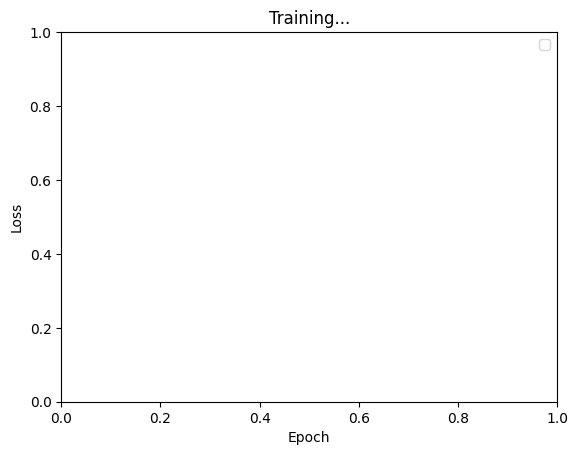

d:\0_Program_Files\Python3.11\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: 

In [14]:
# Train function

import realtime_graph as graph
import gc

epochresults = []
epoch_valloss = 0 
correct = 0
total = 0
graph.startplot()


for epoch in range(epochs):
    
    running_loss = 0.0
    running_valloss = 0.0

    myresnetmodel.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = myresnetmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    myresnetmodel.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss

    with torch.no_grad():

        for idx, data in enumerate(testloader):

            inputs, labels = data
            #---load data into GPU----
            inputs = inputs.to(device)
            labels = labels.to(device)

            #forward pass
            outputs = myresnetmodel.forward(inputs)
            loss = CrossEntropyLossCriterion(outputs, labels)

            # record validation loss
            running_valloss += loss.item()

            # count correct predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        

        epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])

    
    graph.realtimeplot(epochresults)

   
    if epoch_vallos_previous-limit < epoch_valloss < epoch_vallos_previous+limit and epoch_valloss<0.01:
        print("Early stopping")
        break

In [ ]:
print(f'Accuracy of the network on the validation set: {100 * correct // total} %')

In [ ]:
dataset_path_test = "D:/apple_disease_classification/Test/"

transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([resizevalue ,resizevalue]),
    transforms.Normalize(mean = [0.6453, 0.4631, 0.3085],
                          std= [0.2000, 0.2238, 0.2254]),
])
dataset_test = ImageFolder(dataset_path_test, transform=transform_img_normal)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=test_batchsize, shuffle=False)

In [ ]:
print(dataset_path_test)

In [ ]:
dataset_test.class_to_idx

In [ ]:
# Get the length of the data in dataset_test_loader
num_images = len(dataset_test_loader.dataset)
print(f"Number of images: {num_images}")

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad(): #not calling .backward() == efficiency
    #for idx, data in enumerate(dataset_test_loader):
    for data in dataset_test_loader:
        inputs, labels = data
        
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myresnetmodel.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print predicted and label values
        #for i in range(len(labels)):
        #   print(f"Predicted: {predicted[i]}, Label: {labels[i]}")
            
        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[predicted[i]][labels[i]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)
print(total)

In [ ]:
width, height = confusion_matrix.shape
normtotal = 0
normcorrect = confusion_matrix[1][1]
for i in range(height):
    normtotal += confusion_matrix[i][1]

accuracy_normal_apple = round((normcorrect/normtotal)*100, 1)

print('Accuracy on Normal Apples:'+str(accuracy_normal_apple)+'%')

In [ ]:
# Define class labels
class_labels = ['Blotch', 'Normal', 'Rot', 'Scab']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(confusion_matrix, cmap='Greens')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis ticks and labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=10)
ax.set_yticklabels(class_labels, fontsize=10)

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=90, ha="center",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Set the title
ax.set_title("Confusion Matrix: 120 Samples")

# Display axis meaning
ax.text(0.5, -0.15, f"True Class", transform=ax.transAxes,
        fontsize=12, ha='center')
ax.text(-0.15, 0.3, f"Predicted Class", rotation=90, transform=ax.transAxes,
        fontsize=12, ha='center')


# Show the figure
plt.tight_layout()
plt.show()


In [ ]:
confusion_matrix = [[21., 4., 0., 1.],
                    [0., 18., 0., 1.],
                    [0., 2., 37., 4.],
                    [9., 0., 1., 22.]]

In [ ]:
#precision = TP / TP + FP = 18 / (18+1) = 18/19 actual % normal apples of all the predicted normal apples (19) 
precision = confusion_matrix[1][1] / sum(confusion_matrix[1])
print(f'normal apple correctly predicted/precision:',precision)
#recall = TP / TP + FN = 18 / (18+4+2) = 18/26 correctly identifying actual normal apples (26)
column_sum = sum(row[1] for row in confusion_matrix)
recall = confusion_matrix[1][1]/column_sum
print(f'identifying normal apples/recall',recall)

In [ ]:

torch.save(myresnetmodel, 'apple_resnet_classifier.pt')

In [ ]:
#AQL Classifier
def AQLcalc(score):
    if score <= 0.4: return 'Class I'
    if 0.4 > score <=6.5: return 'Class II'
    if 6.5 > score < 15: return 'Class III'
    return 'Class IV'

In [ ]:
# >>> from torchmetrics.classification import MulticlassConfusionMatrix
# >>> target = torch.tensor([2, 1, 0, 0])
# >>> preds = torch.tensor([
# ...   [0.16, 0.26, 0.58],
# ...   [0.22, 0.61, 0.17],
# ...   [0.71, 0.09, 0.20],
# ...   [0.05, 0.82, 0.13],
# ... ])
# >>> metric = MulticlassConfusionMatrix(num_classes=3)
# >>> metric(preds, target)
# tensor([[1, 1, 0],
#         [0, 1, 0],
#         [0, 0, 1]])

In [ ]:
# from torchvision.datasets import ImageFolder
# from torchvision import transforms
# folder_url = r"D:\apple_50sample"

# transform_img_normal = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
# ])

# dataset = ImageFolder(folder_url, transform=transform_img_normal)
